Init, set our service principal credz and load a local image

In [4]:
from IPython import display
from PIL import Image, ImageDraw
import io
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "photo-manager-proto-97c81b37f3da.json" 

from functools import reduce
from google.cloud import vision

client = vision.ImageAnnotatorClient()

file_path = os.path.abspath('christer.jpg')
# Loads the image into memory
# Let's just get the plain binary data as bytes
with io.open(file_path, 'rb', ) as image_file:
    image_content = image_file.read()
    pimage = Image.open(fp=image_file).convert("RGBA")
    pimage.load()

# PIL should hadle opening from these bytes (though not emit them if read elseways?!=).

# g.c.vision.Image also supports bytes while instansiating. a little bit of
# "luck, do not have to getstyck here for a couple of more hours contemplating
# why not and getting annoyed that I yet again haave suvh a hard ome
# understanding the workings... maybe rage-quiitting, promiding myself like so
# many times before that this was the last time and that I've gotton it now....
# =)
image = vision.Image(content=image_content)

In [5]:
print("=== Labels:")
response = client.label_detection(image=image)
labels = response.label_annotations
print(response)
print(labels)
#for label in label_results.label_annotations:
#    print(f'{label.description} - {label.score}')

=== Labels:
label_annotations {
  mid: "/m/025kyy"
  description: "Forehead"
  score: 0.9846563935279846
  topicality: 0.9846563935279846
}
label_annotations {
  mid: "/m/06z04"
  description: "Skin"
  score: 0.9737117290496826
  topicality: 0.9737117290496826
}
label_annotations {
  mid: "/m/04hgtk"
  description: "Head"
  score: 0.9720921516418457
  topicality: 0.9720921516418457
}
label_annotations {
  mid: "/m/0f9swq"
  description: "Chin"
  score: 0.9662540555000305
  topicality: 0.9662540555000305
}
label_annotations {
  mid: "/m/05s2s"
  description: "Plant"
  score: 0.9560278654098511
  topicality: 0.9560278654098511
}
label_annotations {
  mid: "/m/027n3_"
  description: "Eyebrow"
  score: 0.9406071305274963
  topicality: 0.9406071305274963
}
label_annotations {
  mid: "/m/01ssh5"
  description: "Shoulder"
  score: 0.936034619808197
  topicality: 0.936034619808197
}
label_annotations {
  mid: "/m/015h_t"
  description: "Beard"
  score: 0.9101094007492065
  topicality: 0.910109

In [6]:
print('=== safe search:')
response = client.safe_search_detection(image=image)
safe = response.safe_search_annotation
print(response)
# print(safe)

=== safe search:
safe_search_annotation {
  adult: VERY_UNLIKELY
  spoof: UNLIKELY
  medical: VERY_UNLIKELY
  violence: VERY_UNLIKELY
  racy: VERY_UNLIKELY
}



In [7]:
print('=== Landmarks:')
response = client.landmark_detection(image=image)
print(response)
landmarks = response.landmark_annotations

for landmark in landmarks:
    print(landmark.description)
    for location in landmark.locations:
        lat_lng = location.lat_lng
        print('Latitude {}'.format(lat_lng.latitude))
        print('Longitude {}'.format(lat_lng.longitude))

=== Landmarks:



Faces

=== faces:

Face #0, bounds: (228,225), (674,225), (674,744), (228,744)

bounding_poly {
  vertices {
    x: 228
    y: 225
  }
  vertices {
    x: 674
    y: 225
  }
  vertices {
    x: 674
    y: 744
  }
  vertices {
    x: 228
    y: 744
  }
}
fd_bounding_poly {
  vertices {
    x: 323
    y: 311
  }
  vertices {
    x: 695
    y: 311
  }
  vertices {
    x: 695
    y: 699
  }
  vertices {
    x: 323
    y: 699
  }
}
landmarks {
  type_: LEFT_EYE
  position {
    x: 473.4122314453125
    y: 467.15765380859375
    z: -1.52587890625e-05
  }
}
landmarks {
  type_: RIGHT_EYE
  position {
    x: 583.8057250976562
    y: 466.9209289550781
    z: 87.11831665039062
  }
}
landmarks {
  type_: LEFT_OF_LEFT_EYEBROW
  position {
    x: 431.79559326171875
    y: 438.9130859375
    z: -18.31812286376953
  }
}
landmarks {
  type_: RIGHT_OF_LEFT_EYEBROW
  position {
    x: 524.1748046875
    y: 438.7742919921875
    z: 5.724897384643555
  }
}
landmarks {
  type_: LEFT_OF_RIGHT_EYEBROW
  position {


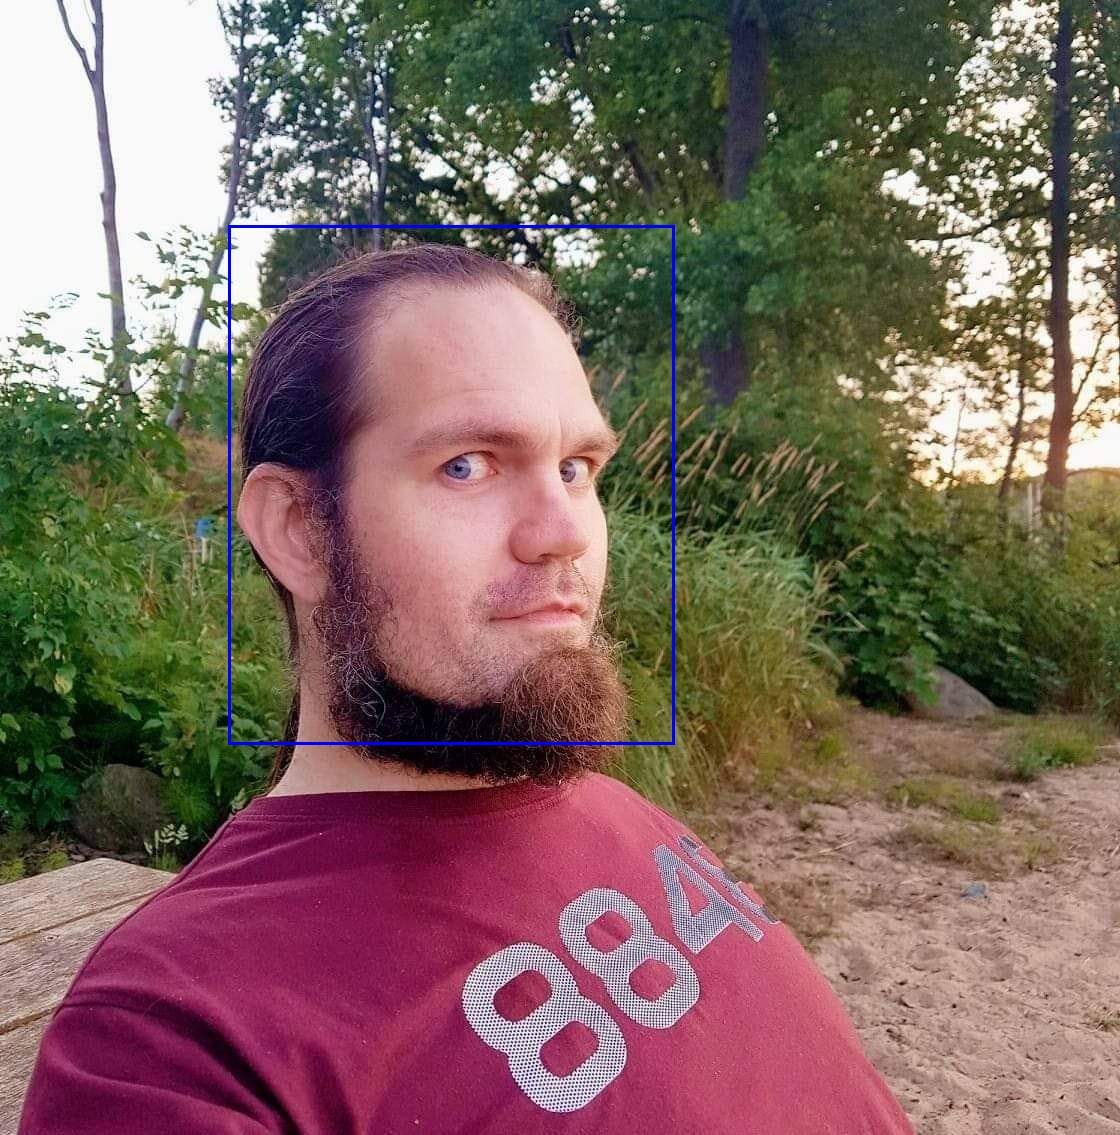

In [9]:
print('=== faces:')
response = client.face_detection(image=image)
faces = response.face_annotations
# print(response) printing faces or the response seem to output prettu mush the the same thing
# print(faces)

for i, face in enumerate(faces):
    print()

    vertices = (['({},{})'.format(vertex.x, vertex.y) for vertex in face.bounding_poly.vertices]) 
    print(f'Face #{i}, bounds: {", ".join(vertices)}')
    xs = list(map(lambda v: v.x, face.bounding_poly.vertices))
    ys = list(map(lambda v: v.y, face.bounding_poly.vertices))
    draw = ImageDraw.Draw(pimage)
    draw.rectangle((min(xs), min(ys), max(xs), max(ys)), outline="blue", width=3)
    print()
    print(face)
    
    display.display(pimage)
    # for mark in face.landmarks:
    #     print(f'{mark.type_}({mark.position.x},{mark.position.y},{mark.position.z})')